In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt
import torch
from tqdm.notebook import tqdm_notebook
import torch.nn.functional as F
import torch.nn as nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

if torch.cuda.is_available():
  device = torch.device("cuda:0")
  torch.backends.cudnn.deterministic = True
else:
  device = torch.device("cpu")

In [2]:
# Hyperparameters
random_seed = 1
batch_size = 64
learning_rate = 0.01
epochs = 20

#Architecture
input = 784
hidden1 = 512
hidden2 = 256
output = 10

In [3]:
train = datasets.MNIST(root = '/data', download = True, transform = transforms.ToTensor(), train = True)
test = datasets.MNIST(root = '/data', transform = transforms.ToTensor(), train = False)

train_dataloader = DataLoader(dataset = train, batch_size = batch_size, shuffle = True)
test_dataloader = DataLoader(dataset = test, batch_size = batch_size, shuffle = False)

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
class LogisticRegressionModel(nn.Module):
  def __init__(self, input, output):
    super(LogisticRegressionModel, self).__init__()

    self.lin1 = nn.Linear(input, hidden1)
    self.lin2 = nn.Linear(hidden1, hidden2)
    self.lin3 = nn.Linear(hidden2, output)

  def forward(self, x):
    x = F.relu(self.lin1(x))
    x = F.relu(self.lin2(x))
    out = self.lin3(x)

    return out

torch.manual_seed(random_seed)
model = LogisticRegressionModel(input, output).to(device)

In [5]:
criteria = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

In [6]:
def compute_accuracy(model, dataloader):
  correct = 0
  total = 0

  model.eval()
  with torch.no_grad():
    for images, labels in dataloader:
      images = images.view(-1, 28*28).to(device)
      labels = labels.to(device)
      
      outputs = model(images)

      preds = F.softmax(outputs)
      _, predictions = torch.max(preds,1)

      total += len(labels)
      correct += (predictions == labels).sum()

      return (correct/total)*100

In [7]:
start = time.time()
ep = []
train_loss = []
train_acc = []
for epoch in tqdm_notebook(range(epochs), desc = 'Epoch progress'):
  for batch_idx, (images, labels) in tqdm_notebook(enumerate(train_dataloader), desc = 'Batch Training'):
    images = images.view(-1, 28*28).to(device)
    labels = labels.to(device)

    outputs = model(images)

    loss = criteria(outputs, labels)
    # ep.append(epoch)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if batch_idx % 300 == 0:
      print('Epoch: {}/{} | Batch: {}/{} | Train Loss = {:.4f}'.format(epoch, epochs, batch_idx, len(train_dataloader), loss))
  acc = compute_accuracy(model, train_dataloader)  
  print('For Epoch: {}/{}, Training Accuracy is: {}'.format(epoch, epochs, acc))
  ep.append(epoch); train_acc.append(acc); train_loss.append(loss)
  print('Time taken for epoch {}/{} : {}'.format(epoch, epochs, (time.time()-start)/60))
print('Total Training Time taken : {}'.format((time.time()-start)/60))

Epoch: 0/20 | Batch: 0/938 | Train Loss = 2.3096
Epoch: 0/20 | Batch: 300/938 | Train Loss = 2.0218
Epoch: 0/20 | Batch: 600/938 | Train Loss = 1.2978
Epoch: 0/20 | Batch: 900/938 | Train Loss = 0.6005

For Epoch: 0/20, Training Accuracy is: 85.9375
Time taken for epoch 0/20 : 0.09001118739446004


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  del sys.path[0]


Epoch: 1/20 | Batch: 0/938 | Train Loss = 0.6009
Epoch: 1/20 | Batch: 300/938 | Train Loss = 0.5611
Epoch: 1/20 | Batch: 600/938 | Train Loss = 0.5216
Epoch: 1/20 | Batch: 900/938 | Train Loss = 0.3922

For Epoch: 1/20, Training Accuracy is: 79.6875
Time taken for epoch 1/20 : 0.17883014281590778


Epoch: 2/20 | Batch: 0/938 | Train Loss = 0.3349
Epoch: 2/20 | Batch: 300/938 | Train Loss = 0.2962
Epoch: 2/20 | Batch: 600/938 | Train Loss = 0.2942
Epoch: 2/20 | Batch: 900/938 | Train Loss = 0.2489

For Epoch: 2/20, Training Accuracy is: 90.625
Time taken for epoch 2/20 : 0.26600218613942467


Epoch: 3/20 | Batch: 0/938 | Train Loss = 0.2484
Epoch: 3/20 | Batch: 300/938 | Train Loss = 0.2367
Epoch: 3/20 | Batch: 600/938 | Train Loss = 0.4029
Epoch: 3/20 | Batch: 900/938 | Train Loss = 0.6615

For Epoch: 3/20, Training Accuracy is: 90.625
Time taken for epoch 3/20 : 0.3532910943031311


Epoch: 4/20 | Batch: 0/938 | Train Loss = 0.2292
Epoch: 4/20 | Batch: 300/938 | Train Loss = 0.2135
Epoch: 4/20 | Batch: 600/938 | Train Loss = 0.1825
Epoch: 4/20 | Batch: 900/938 | Train Loss = 0.3393

For Epoch: 4/20, Training Accuracy is: 90.625
Time taken for epoch 4/20 : 0.4401221474011739


Epoch: 5/20 | Batch: 0/938 | Train Loss = 0.3714
Epoch: 5/20 | Batch: 300/938 | Train Loss = 0.3934
Epoch: 5/20 | Batch: 600/938 | Train Loss = 0.1492
Epoch: 5/20 | Batch: 900/938 | Train Loss = 0.2349

For Epoch: 5/20, Training Accuracy is: 95.3125
Time taken for epoch 5/20 : 0.5273290514945984


Epoch: 6/20 | Batch: 0/938 | Train Loss = 0.4832
Epoch: 6/20 | Batch: 300/938 | Train Loss = 0.1945
Epoch: 6/20 | Batch: 600/938 | Train Loss = 0.3161
Epoch: 6/20 | Batch: 900/938 | Train Loss = 0.2188

For Epoch: 6/20, Training Accuracy is: 85.9375
Time taken for epoch 6/20 : 0.6156037131945292


Epoch: 7/20 | Batch: 0/938 | Train Loss = 0.2080
Epoch: 7/20 | Batch: 300/938 | Train Loss = 0.2730
Epoch: 7/20 | Batch: 600/938 | Train Loss = 0.3281
Epoch: 7/20 | Batch: 900/938 | Train Loss = 0.3040

For Epoch: 7/20, Training Accuracy is: 93.75
Time taken for epoch 7/20 : 0.7038560271263122


Epoch: 8/20 | Batch: 0/938 | Train Loss = 0.2258
Epoch: 8/20 | Batch: 300/938 | Train Loss = 0.3146
Epoch: 8/20 | Batch: 600/938 | Train Loss = 0.2171
Epoch: 8/20 | Batch: 900/938 | Train Loss = 0.3579

For Epoch: 8/20, Training Accuracy is: 93.75
Time taken for epoch 8/20 : 0.7926819721857706


Epoch: 9/20 | Batch: 0/938 | Train Loss = 0.1367
Epoch: 9/20 | Batch: 300/938 | Train Loss = 0.1773
Epoch: 9/20 | Batch: 600/938 | Train Loss = 0.2898
Epoch: 9/20 | Batch: 900/938 | Train Loss = 0.1929

For Epoch: 9/20, Training Accuracy is: 89.0625
Time taken for epoch 9/20 : 0.8806908965110779


Epoch: 10/20 | Batch: 0/938 | Train Loss = 0.1500
Epoch: 10/20 | Batch: 300/938 | Train Loss = 0.2366
Epoch: 10/20 | Batch: 600/938 | Train Loss = 0.2028
Epoch: 10/20 | Batch: 900/938 | Train Loss = 0.2001

For Epoch: 10/20, Training Accuracy is: 96.875
Time taken for epoch 10/20 : 0.9687340974807739


Epoch: 11/20 | Batch: 0/938 | Train Loss = 0.2003
Epoch: 11/20 | Batch: 300/938 | Train Loss = 0.1874
Epoch: 11/20 | Batch: 600/938 | Train Loss = 0.1708
Epoch: 11/20 | Batch: 900/938 | Train Loss = 0.1332

For Epoch: 11/20, Training Accuracy is: 93.75
Time taken for epoch 11/20 : 1.0568918387095134


Epoch: 12/20 | Batch: 0/938 | Train Loss = 0.0630
Epoch: 12/20 | Batch: 300/938 | Train Loss = 0.0612
Epoch: 12/20 | Batch: 600/938 | Train Loss = 0.1194
Epoch: 12/20 | Batch: 900/938 | Train Loss = 0.1058

For Epoch: 12/20, Training Accuracy is: 90.625
Time taken for epoch 12/20 : 1.1457183361053467


Epoch: 13/20 | Batch: 0/938 | Train Loss = 0.0670
Epoch: 13/20 | Batch: 300/938 | Train Loss = 0.1600
Epoch: 13/20 | Batch: 600/938 | Train Loss = 0.1724
Epoch: 13/20 | Batch: 900/938 | Train Loss = 0.1715

For Epoch: 13/20, Training Accuracy is: 93.75
Time taken for epoch 13/20 : 1.234512174129486


Epoch: 14/20 | Batch: 0/938 | Train Loss = 0.2739
Epoch: 14/20 | Batch: 300/938 | Train Loss = 0.1141
Epoch: 14/20 | Batch: 600/938 | Train Loss = 0.1697
Epoch: 14/20 | Batch: 900/938 | Train Loss = 0.0706

For Epoch: 14/20, Training Accuracy is: 93.75
Time taken for epoch 14/20 : 1.3220465938250223


Epoch: 15/20 | Batch: 0/938 | Train Loss = 0.2251
Epoch: 15/20 | Batch: 300/938 | Train Loss = 0.2071
Epoch: 15/20 | Batch: 600/938 | Train Loss = 0.0649
Epoch: 15/20 | Batch: 900/938 | Train Loss = 0.0775

For Epoch: 15/20, Training Accuracy is: 98.4375
Time taken for epoch 15/20 : 1.4093451897303264


Epoch: 16/20 | Batch: 0/938 | Train Loss = 0.1100
Epoch: 16/20 | Batch: 300/938 | Train Loss = 0.3372
Epoch: 16/20 | Batch: 600/938 | Train Loss = 0.1159
Epoch: 16/20 | Batch: 900/938 | Train Loss = 0.1983

For Epoch: 16/20, Training Accuracy is: 95.3125
Time taken for epoch 16/20 : 1.4971688310305278


Epoch: 17/20 | Batch: 0/938 | Train Loss = 0.1432
Epoch: 17/20 | Batch: 300/938 | Train Loss = 0.1014
Epoch: 17/20 | Batch: 600/938 | Train Loss = 0.1059
Epoch: 17/20 | Batch: 900/938 | Train Loss = 0.0744

For Epoch: 17/20, Training Accuracy is: 96.875
Time taken for epoch 17/20 : 1.5857025464375814


Epoch: 18/20 | Batch: 0/938 | Train Loss = 0.1251
Epoch: 18/20 | Batch: 300/938 | Train Loss = 0.0481
Epoch: 18/20 | Batch: 600/938 | Train Loss = 0.1804
Epoch: 18/20 | Batch: 900/938 | Train Loss = 0.0904

For Epoch: 18/20, Training Accuracy is: 98.4375
Time taken for epoch 18/20 : 1.6749330242474874


Epoch: 19/20 | Batch: 0/938 | Train Loss = 0.0810
Epoch: 19/20 | Batch: 300/938 | Train Loss = 0.0953
Epoch: 19/20 | Batch: 600/938 | Train Loss = 0.0961
Epoch: 19/20 | Batch: 900/938 | Train Loss = 0.1903

For Epoch: 19/20, Training Accuracy is: 95.3125
Time taken for epoch 19/20 : 1.7643449624379477

Total Training Time taken : 1.7644034465154013


[]

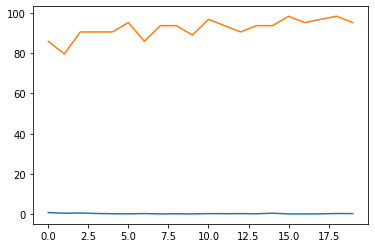

In [8]:
plt.plot(ep,train_loss)
plt.plot(ep,train_acc)
plt.plot()